# Generate an ELL model from the CNTK model

In [1]:
%matplotlib inline

In [24]:
import sys
import glob
import cv2
import numpy as np

## Settings

In [6]:
output_path = "/data/out"
cntk_model_file = os.path.join(output_path, 'DrinksTransferLearning-VGG2.model')

In [7]:
python_bin = sys.executable
ell_path = "/data/ELL"
ell_build_path = os.path.join(ell_path, 'build')

In [37]:
ell_model_file = "/data/vgg16ImageNet.map"

In [17]:
subset = glob.glob("/data/drinks/valid/*/img*4.jpg")

In [33]:
labels_path = "/data/drinks/labels.txt"

In [34]:
%%bash -s "$labels_path"
cat /dev/null > $1
echo evian >> $1
echo valser >> $1
echo coke >> $1

Run ngrok on your Raspberry Pi

In [42]:
raspberry_ssh_host="pi@0.tcp.eu.ngrok.io"

raspberry_ssh_port=12688

In [43]:
%%bash -s "$raspberry_ssh_host" "$raspberry_ssh_port"
ssh -p $2 $1 "echo Successfully connected"

Successfully connected


## Utility functions

In [25]:
import matplotlib.pyplot as plt
import cv2

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


# Convert CNTK model to ELL model

In [9]:
import sys
sys.path.append(os.path.join(ell_build_path, 'tools/importers/CNTK/'))  
from cntk_to_ell import predictor_from_cntk_model
ell_predictor = predictor_from_cntk_model(cntk_model_file)

Loading...

Finished loading.
Pre-processing...

Will not process Dropout - skipping this layer as irrelevant.

Will not process Dropout - skipping this layer as irrelevant.
Convolution :  226x226x3  ->  224x224x64 | input padding 1  output padding 0
ReLU :  224x224x64  ->  226x226x64 | input padding 0  output padding 1
Convolution :  226x226x64  ->  224x224x64 | input padding 1  output padding 0
ReLU :  224x224x64  ->  224x224x64 | input padding 0  output padding 0
MaxPooling :  224x224x64  ->  114x114x64 | input padding 0  output padding 1
Convolution :  114x114x64  ->  112x112x128 | input padding 1  output padding 0
ReLU :  112x112x128  ->  114x114x128 | input padding 0  output padding 1
Convolution :  114x114x128  ->  112x112x128 | input padding 1  output padding 0
ReLU :  112x112x128  ->  112x112x128 | input padding 0  output padding 0
MaxPooling :  112x112x128  ->  58x58x128 | input padding 0  output padding 1
Convolution :  58x58x128  ->  56x56x256 | input padding 1  output padd

In [10]:
sys.path.append(os.path.join(ell_build_path, 'tools/utilities/pythonlibs/'))
import demoHelper as d
helper = d.DemoHelper()
helper.save_ell_predictor_to_file(ell_predictor, ell_model_file)

# Compile ELL model on the host (server)

In [11]:
%%bash -s "$python_bin" "$ell_build_path" "$labels_path" "$ell_model_file"
$1 "$2/tools/wrap/wrap.py" $3 $4 -lang python -target host -outdir host

compiling model...
generating python interfaces for vgg16ImageNet in host
running llc...
success, now you can build the 'host' folder


In [12]:
%%bash
cd host
rm -rf build
mkdir -p build
cd build
PATH=/anaconda/envs/py35/bin:$PATH cmake ..
make

-- The C compiler identification is GNU 5.4.0
-- The CXX compiler identification is GNU 5.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threads: TRUE  
-- Blas libraries: /anaconda/envs/py35/lib/libmkl_intel_lp64.so;/

In [13]:
sys.path.append('host')    
sys.path.append('host/build')    
import vgg16ImageNet as model


# Get the input and output shapes
input_shape = model.get_default_input_shape()
output_shape = model.get_default_output_shape()

print("Model input shape: " + str([input_shape.rows,input_shape.columns,input_shape.channels]))
print("Model output shape: " + str([output_shape.rows,output_shape.columns,output_shape.channels]))



Model input shape: [224, 224, 3]
Model output shape: [1, 1, 3]


Looking for: vgg16ImageNet in host
Found input_shape [224,224,3]


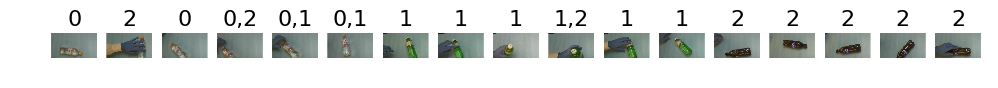

In [36]:
import demoHelper as d
helper = d.DemoHelper()
helper.parse_arguments(("--compiledModel","host/vgg16ImageNet", labels_path), "")

def predict_label(frame):

    # Prepare the image to send to the model.
    # This involves scaling to the required input dimension and re-ordering from BGR to RGB

    data = helper.prepare_image_for_predictor(frame)
    # Get the model to classify the image, by returning a list of probabilities for the classes it can detect
    predictions = helper.predict(data)

    # Get the (at most) top 5 predictions that meet our threshold. This is returned as a list of tuples,
    # each with the text label and the prediction score.
    top5 = helper.get_top_n(predictions, 5)

    text = ",".join(
            [str(element[0]) for element in top5])
    return text


imgs = [cv2.imread(i) for i in subset]
preds = [predict_label(i) for i in imgs]
plots(imgs, titles = preds)

# Compile ELL model on Raspberry Pi

In [38]:
%%bash -s "$python_bin" "$ell_build_path" "$labels_path" "$ell_model_file"
rm -rf pi3
$1 "$2/tools/wrap/wrap.py" $3 $4 -lang python -target pi3 -outdir pi3

compiling model...
generating python interfaces for vgg16ImageNet in pi3
running llc...
success, now copy the pi3 to your target machine and build it there


In [40]:
%%bash -s "$ell_path" "$ell_build_path" "$labels_path"
cp $2/tools/utilities/pythonlibs/demo*.py pi3
cp $2/tools/utilities/pitest/coffeemug.jpg pi3
cp $1/docs/tutorials/shared/demo.py pi3
cp $3 pi3
echo "#!/bin/bash\npython demo.py $3 --compiledModel vgg16ImageNet --image coffeemug.jpg --bgr true" > pi3/demo.sh
chmod +x pi3/demo.sh

In [45]:
%%bash -s "$raspberry_ssh_host" "$raspberry_ssh_port"
rsync -a --delete -e "ssh -p $2 -o StrictHostKeyChecking=no" pi3/ $1:pi3/

In [46]:
%%bash -s "$raspberry_ssh_host" "$raspberry_ssh_port"
ssh -p $2 $1 "
set -o errexit
set -o xtrace
source /home/pi/miniconda3/bin/activate py34
cd pi3
rm -rf build
mkdir build
cd build
cmake ..
make
"

-- The C compiler identification is GNU 4.9.2
-- The CXX compiler identification is GNU 4.9.2
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threads: TRUE  
-- Blas libraries: /usr/lib/libopenblas.so
-- Blas linker flags: 

+ source /home/pi/miniconda3/bin/activate py34
++ [[ -n 4.3.30(1)-release ]]
+++ basename bash
++ [[ bash == \a\c\t\i\v\a\t\e ]]
++ [[ -n 4.3.30(1)-release ]]
++ _SCRIPT_LOCATION=/home/pi/miniconda3/bin/activate
+++ dirname /home/pi/miniconda3/bin/activate
++ _THIS_DIR=/home/pi/miniconda3/bin
++ /home/pi/miniconda3/bin/conda ..checkenv py34
++ run_scripts deactivate
++++ echo /usr/local/bin:/usr/bin:/bin:/usr/games
++++ awk -F : '{print $1}'
+++ echo /usr/local/bin/..
++ _PREFIX=/usr/local/bin/..
++ _CONDA_D=/usr/local/bin/../etc/conda/deactivate.d
++ [[ -d /usr/local/bin/../etc/conda/deactivate.d ]]
+++ /home/pi/miniconda3/bin/conda ..deactivate
discarding /home/pi/miniconda3/bin from PATH
++ _NEW_PATH=/usr/local/bin:/usr/bin:/bin:/usr/games
++ export PATH=/usr/local/bin:/usr/bin:/bin:/usr/games
++ PATH=/usr/local/bin:/usr/bin:/bin:/usr/games
+++ /home/pi/miniconda3/bin/conda ..changeps1
++ ((  1  ))
++ [[ -n '' ]]
+++ /home/pi/miniconda3/bin/conda ..activate py34
prepending /home/pi/